In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('realtor-data.csv')

In [3]:
# brokered by (categorically encoded agency/broker)
# status (Housing status - a. ready for sale or b. ready to build)
# price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)
# bed (# of beds)
# bath (# of bathrooms)
# acre_lot (Property / Land size in acres)
# street (categorically encoded street address)
# city (city name)
# state (state name)
# zip_code (postal code of the area)
# house_size (house area/size/living space in square feet)
# prev_sold_date (Previously sold date)

In [4]:
df.head(10)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN
6,1205.0,for_sale,50000.0,3.0,1.0,0.20,1298094.0,Ciales,Puerto Rico,639.0,2040.0,NaN
7,50739.0,for_sale,71600.0,3.0,2.0,0.08,1048466.0,Ponce,Puerto Rico,731.0,1050.0,NaN
8,81909.0,for_sale,100000.0,2.0,1.0,0.09,734904.0,Ponce,Puerto Rico,730.0,1092.0,NaN
9,65672.0,for_sale,300000.0,5.0,3.0,7.46,1946226.0,Las Marias,Puerto Rico,670.0,5403.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [6]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [7]:
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,"2,221,849.00","2,224,841.00","1,745,065.00","1,714,611.00","1,900,793.00","2,215,516.00","2,226,083.00","1,657,898.00"
mean,"52,939.89","524,195.52",3.28,2.50,15.22,"1,012,324.92","52,186.68","2,714.47"
std,"30,642.75","2,138,893.22",1.57,1.65,762.82,"583,763.48","28,954.08","808,163.52"
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00,4.00
25%,"23,861.00","165,000.00",3.00,2.00,0.15,"506,312.75","29,617.00","1,300.00"
50%,"52,884.00","325,000.00",3.00,2.00,0.26,"1,012,765.50","48,382.00","1,760.00"
75%,"79,183.00","550,000.00",4.00,3.00,0.98,"1,521,173.25","78,070.00","2,413.00"
max,"110,142.00","2,147,483,600.00",473.00,830.00,"100,000.00","2,001,357.00","99,999.00","1,040,400,400.00"


# Преобработка данных

In [8]:
# Копируем данные для предобработки
df_clean = df.copy()

# Удаление аномальных значений в цене
# Удаляем цены = 0 и слишком большие
price_q999 = df_clean['price'].quantile(0.999)
df_clean = df_clean[(df_clean['price'] > 0) & (df_clean['price'] < price_q999)]

# Удаление аномальных значений в площади дома
# Ограничиваем разумными пределами (обычно дома до 20,000 кв.футов)
df_clean = df_clean[(df_clean['house_size'] > 0) & (df_clean['house_size'] < 20000)]

# Обработка аномальных значений в количестве спален и ванных
df_clean = df_clean[(df_clean['bed'] >= 1) & (df_clean['bed'] <= 10)]
df_clean = df_clean[(df_clean['bath'] >= 1) & (df_clean['bath'] <= 10)]

# Обработка площади участка 
# Удаляем экстремально большие значения 
lot_q999 = df_clean['acre_lot'].quantile(0.999)
df_clean = df_clean[(df_clean['acre_lot'] >= 0) & (df_clean['acre_lot'] < lot_q999)]

# Удаление строк с пропущенными важными признаками
important_cols = ['price', 'bed', 'bath', 'house_size']
df_clean = df_clean.dropna(subset=important_cols)

# Преобразование zip_code в строковый формат 
df_clean['zip_code'] = df_clean['zip_code'].astype(str).str.split('.').str[0]

# Проверяем оставшиеся данные
print(f"Размер данных после очистки: {df_clean.shape}")
print(f"Процент сохраненных данных: {len(df_clean)/len(df)*100:.2f}%")



Размер данных после очистки: (1354785, 12)
Процент сохраненных данных: 60.85%


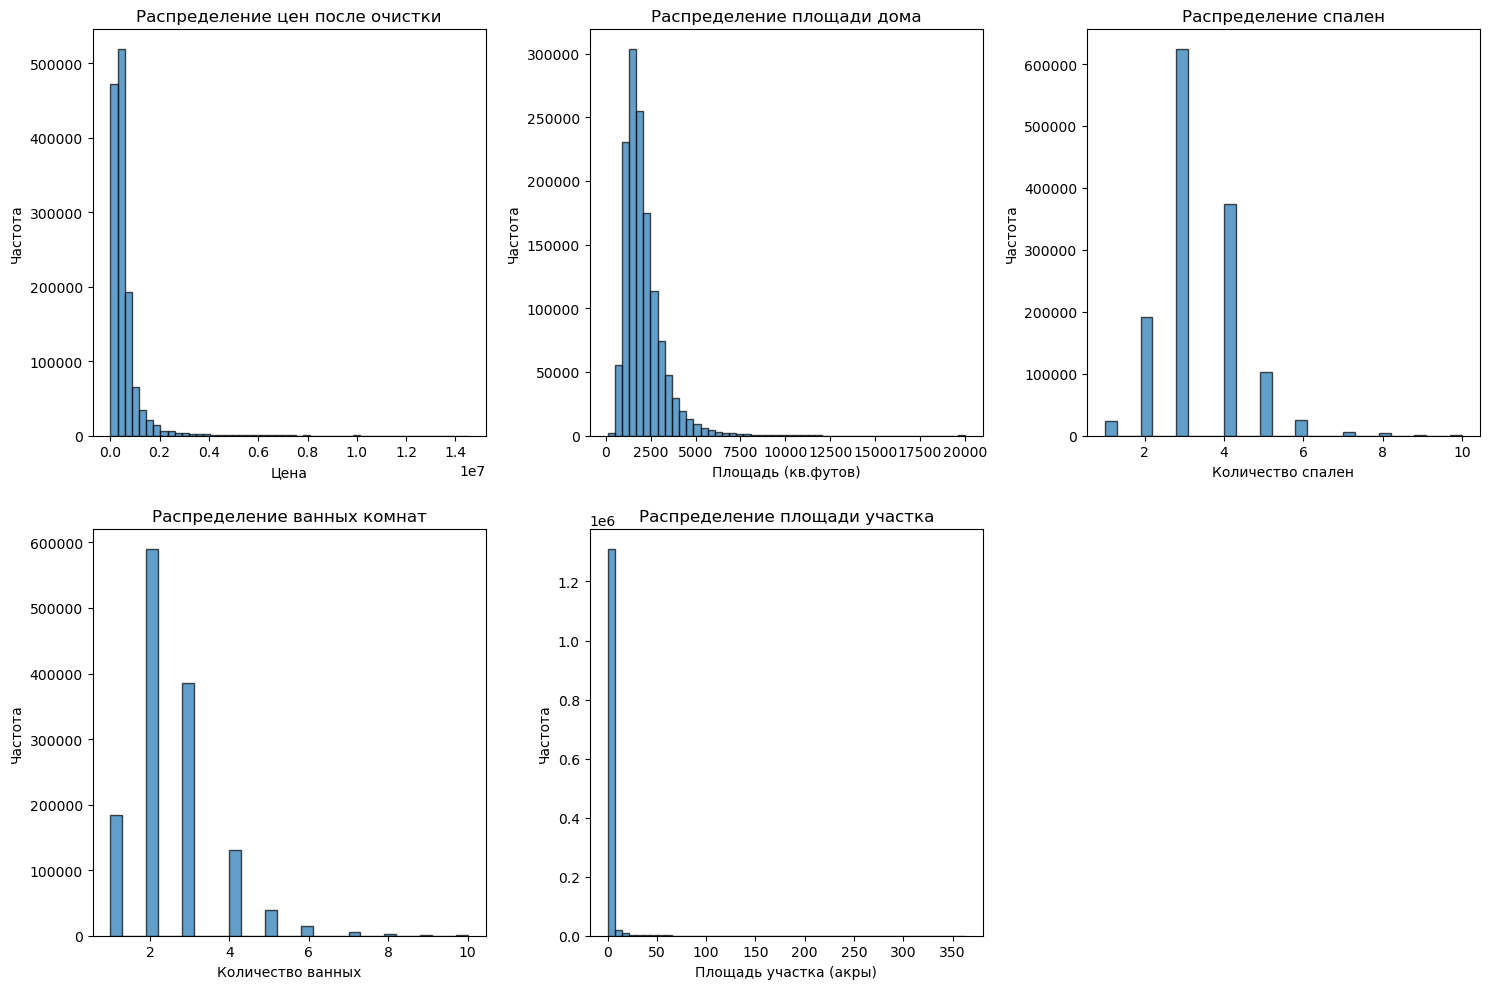

In [9]:
# Визуализация распределения ключевых признаков после очистки
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Цена
axes[0, 0].hist(df_clean['price'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение цен после очистки')
axes[0, 0].set_xlabel('Цена')
axes[0, 0].set_ylabel('Частота')

# Площадь дома
axes[0, 1].hist(df_clean['house_size'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Распределение площади дома')
axes[0, 1].set_xlabel('Площадь (кв.футов)')
axes[0, 1].set_ylabel('Частота')

# Количество спален
axes[0, 2].hist(df_clean['bed'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Распределение спален')
axes[0, 2].set_xlabel('Количество спален')
axes[0, 2].set_ylabel('Частота')

# Количество ванных
axes[1, 0].hist(df_clean['bath'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Распределение ванных комнат')
axes[1, 0].set_xlabel('Количество ванных')
axes[1, 0].set_ylabel('Частота')

# Площадь участка
axes[1, 1].hist(df_clean['acre_lot'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Распределение площади участка')
axes[1, 1].set_xlabel('Площадь участка (акры)')
axes[1, 1].set_ylabel('Частота')

# Убираем пустую ячейку
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


Статистики после очистки:
              price          bed         bath   house_size     acre_lot
count  1,354,785.00 1,354,785.00 1,354,785.00 1,354,785.00 1,354,785.00
mean     543,705.55         3.35         2.51     2,072.52         1.56
std      700,955.13         1.03         1.11     1,124.28         9.86
min            1.00         1.00         1.00       100.00         0.00
25%      239,000.00         3.00         2.00     1,360.00         0.14
50%      377,500.00         3.00         2.00     1,809.00         0.21
75%      599,900.00         4.00         3.00     2,468.00         0.46
max   14,499,000.00        10.00        10.00    19,998.00       362.50


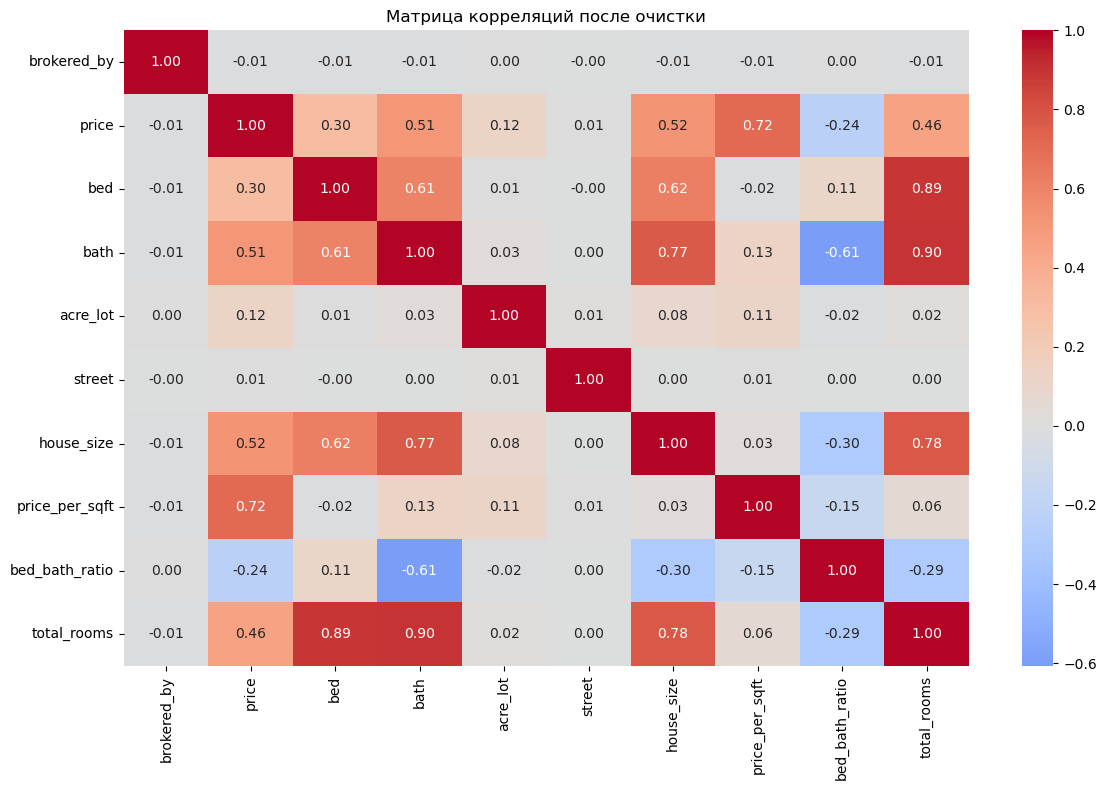


Очищенные данные сохранены. Размер: (1354785, 15)


In [10]:
# Проверка статистик после очистки
print("\nСтатистики после очистки:")
print(df_clean[['price', 'bed', 'bath', 'house_size', 'acre_lot']].describe())

# Создание дополнительных признаков 
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['house_size']
df_clean['bed_bath_ratio'] = df_clean['bed'] / df_clean['bath']
df_clean['total_rooms'] = df_clean['bed'] + df_clean['bath']

# Заполнение пропущенных значений для остальных признаков
# Для числовых признаков - медианой
numeric_cols = ['acre_lot', 'brokered_by']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

categorical_cols = ['city', 'state', 'status']
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown')

# Корреляционный анализ числовых признаков
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций после очистки')
plt.tight_layout()
plt.show()

# Сохранение очищенных данных
df_clean.to_csv('realtor-data-cleaned.csv', index=False)
print(f"\nОчищенные данные сохранены. Размер: {df_clean.shape}")

# Визуализация

Price range: 0 - 2147483600
Mean price: 524195
Median price: 325000
Standard deviation: 2138893


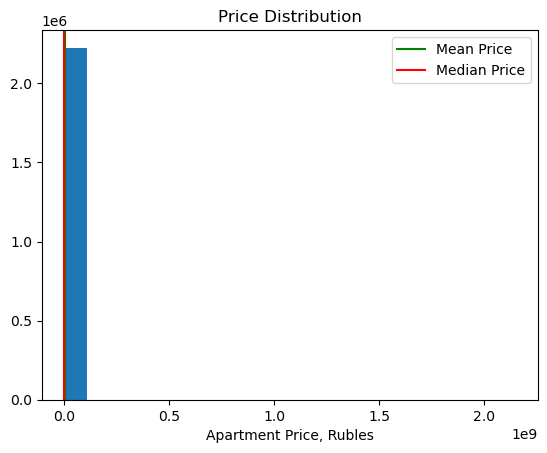

In [11]:
mean_price = int(df['price'].mean())
median_price = int(df['price'].median())

std = int(df['price'].std())

min_price = int(df['price'].min())
max_price = int(df['price'].max())

print(f'Price range: {min_price} - {max_price}')
print(f'Mean price: {mean_price}\nMedian price: {median_price}')
print(f'Standard deviation: {std}')

plt.hist(df['price'], bins=20)
plt.axvline(mean_price, label='Mean Price', color='green')
plt.axvline(median_price, label='Median Price', color='red')
plt.legend()
plt.xlabel('Apartment Price, Rubles')
plt.title('Price Distribution')
plt.show()

### Средняя стоимость 524 195

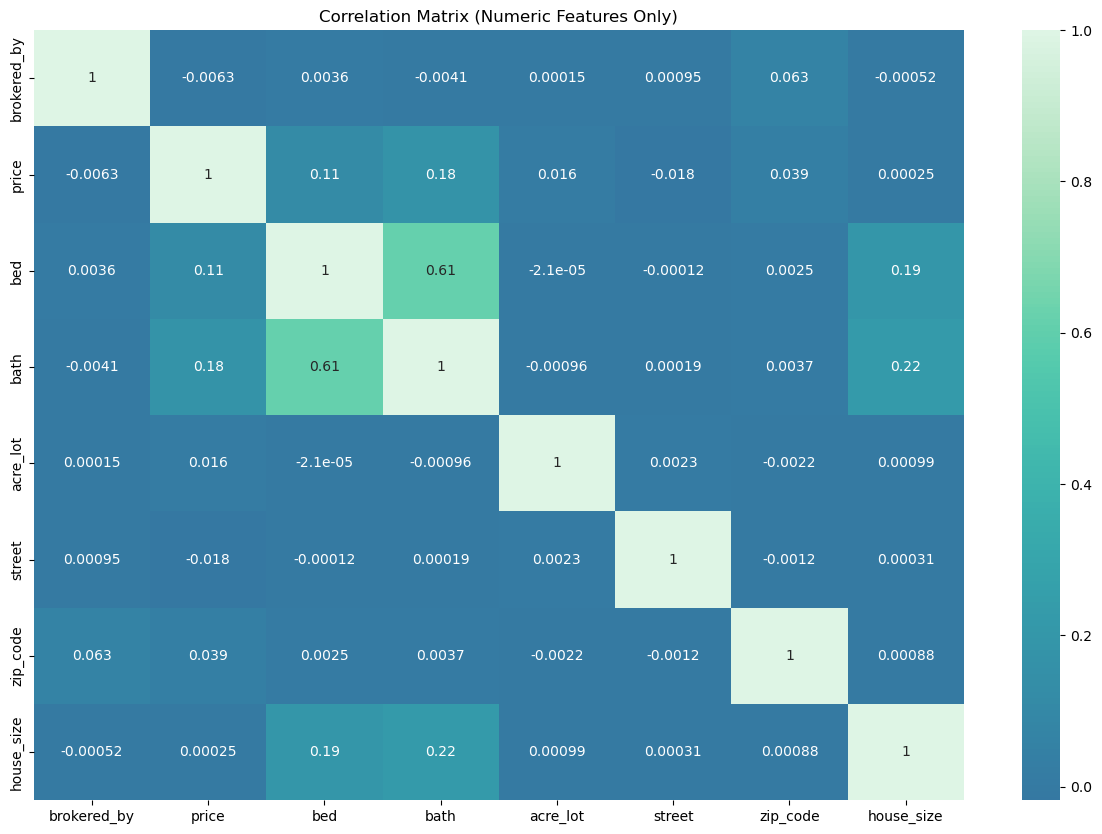

In [12]:
plt.figure(figsize=(15, 10))
# Выбираем только числовые столбцы
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), center=0, cmap='mako', annot=True)
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

### Корреляционная матрица показывает очень слабые корреляции. Это может быть связано с выбросами в данных.

In [13]:
# удалим выбросы из числовых данных для более чистого анализа
numeric_df = df.select_dtypes(include=[np.number]).copy()

In [14]:
# Функция для удаления выбросов 
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [15]:
# Удаляем выбросы из ключевых столбцов 
key_columns = ['price', 'house_size', 'bed', 'bath', 'acre_lot']
numeric_df_clean = numeric_df.copy()
for col in key_columns:
    if col in numeric_df_clean.columns:
        # Сохраняем только строки без выбросов по всем столбцам
        numeric_df_clean = remove_outliers_iqr(numeric_df_clean, col)

print(f"Размер данных после удаления выбросов: {numeric_df_clean.shape}")

Размер данных после удаления выбросов: (977050, 8)


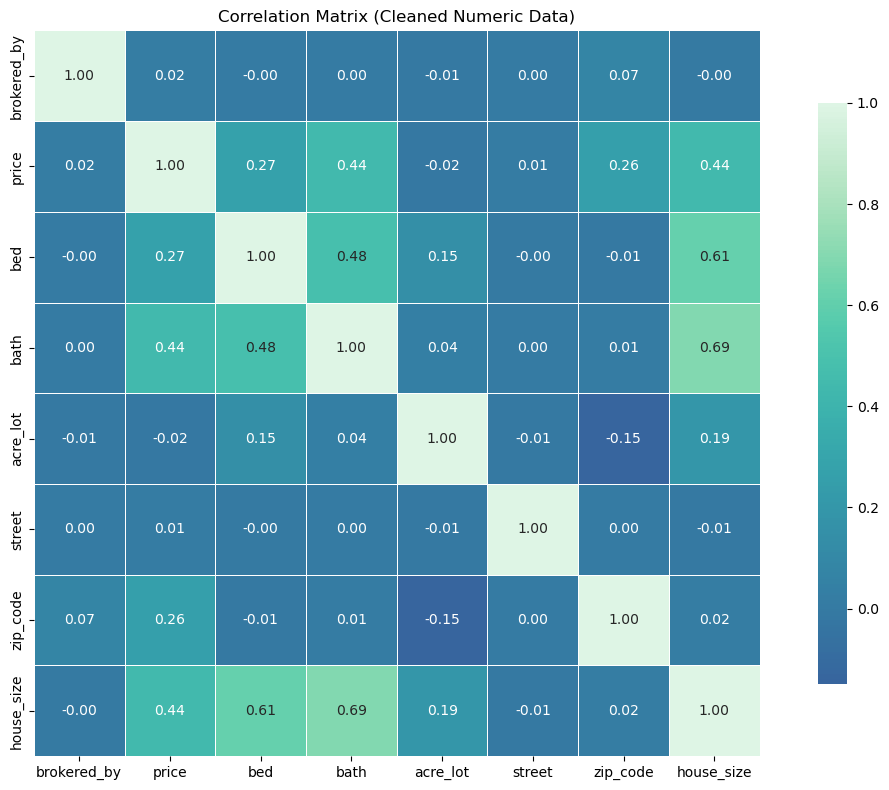

In [16]:
# Корреляционная матрица после очистки от выбросов
plt.figure(figsize=(12, 8))
corr_matrix = numeric_df_clean.corr()
sns.heatmap(corr_matrix, 
            center=0, 
            cmap='mako', 
            annot=True,
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Cleaned Numeric Data)')
plt.tight_layout()
plt.show()

In [17]:
# Анализ корреляционной матрицы
print("ДЕТАЛЬНЫЙ АНАЛИЗ КОРРЕЛЯЦИОННОЙ МАТРИЦЫ")
# Анализ корреляций с ценой (целевой переменной)
print("\n КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕНОЙ (убывание):")
price_corr = corr_matrix['price'].sort_values(ascending=False)

for feature, corr_value in price_corr.items():
    if feature != 'price':  # исключаем сам price
        strength = ""
        if abs(corr_value) > 0.7:
            strength = "ОЧЕНЬ СИЛЬНАЯ"
        elif abs(corr_value) > 0.5:
            strength = "СИЛЬНАЯ"
        elif abs(corr_value) > 0.3:
            strength = "УМЕРЕННАЯ"
        elif abs(corr_value) > 0.1:
            strength = "СЛАБАЯ"
        else:
            strength = "ОЧЕНЬ СЛАБАЯ"
        
        direction = "положительная" if corr_value > 0 else "отрицательная"
        print(f"  {feature:15} : {corr_value:.3f} ({strength} {direction})")

ДЕТАЛЬНЫЙ АНАЛИЗ КОРРЕЛЯЦИОННОЙ МАТРИЦЫ

 КОРРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕНОЙ (убывание):
  bath            : 0.441 (УМЕРЕННАЯ положительная)
  house_size      : 0.439 (УМЕРЕННАЯ положительная)
  bed             : 0.268 (СЛАБАЯ положительная)
  zip_code        : 0.255 (СЛАБАЯ положительная)
  brokered_by     : 0.018 (ОЧЕНЬ СЛАБАЯ положительная)
  street          : 0.010 (ОЧЕНЬ СЛАБАЯ положительная)
  acre_lot        : -0.021 (ОЧЕНЬ СЛАБАЯ отрицательная)


# Создание моделей

## Классическая модель

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [19]:
X, y = numeric_df_clean.drop('price', axis=1), numeric_df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [20]:
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 регуляризация
    reg_lambda=1,    # L2 регуляризация
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'  # Важно для регрессии!
)

In [21]:
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
y_pred = model.predict(X_test)

In [23]:
print("Результаты XGBoost регрессии:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

Результаты XGBoost регрессии:
MAE: 87210.47
MSE: 14804964222.28
RMSE: 121675.65
R²: 0.6890


### XGBoost показал лучшие результаты R² = 0.689 против 0.538 у нейросети
## Причины
### Табличные данные с малым количеством признаков
### Устойчив к выбросам
### Минимальная настройка гиперпараметров

# Нейронная модель

In [24]:
# Заполнение пропусков
X = X.fillna(X.median())

In [25]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
# Масштабирование
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [27]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [28]:
tf.keras.backend.clear_session()

In [29]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', 
                      kernel_initializer='he_normal',
                      kernel_regularizer=keras.regularizers.l2(0.001),
                      input_shape=(X_train_scaled.shape[1],)),
    
    keras.layers.BatchNormalization(),
    
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(32, activation='relu',
                      kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    
    keras.layers.Dense(16, activation='relu',
                      kernel_initializer='he_normal'),
    
    keras.layers.Dense(1, kernel_initializer='glorot_uniform')
])


In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Среднеквадратичная ошибка
    metrics=['mae']  # Средняя абсолютная ошибка
)

In [31]:
history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.2,  # 20% данных для валидации
    epochs=30,  # Уменьшено с 150 до 30
    batch_size=256,
    verbose=1
)

Epoch 1/30
2443/2443 [==============================] - 8s 3ms/step - loss: 6.5313 - mae: 1.4723 - val_loss: 0.4018 - val_mae: 0.4097
Epoch 2/30
2443/2443 [==============================] - 7s 3ms/step - loss: 1.0339 - mae: 0.7633 - val_loss: 0.3158 - val_mae: 0.3812
Epoch 3/30
2443/2443 [==============================] - 7s 3ms/step - loss: 0.4967 - mae: 0.5173 - val_loss: 0.2498 - val_mae: 0.3521
Epoch 4/30
2443/2443 [==============================] - 7s 3ms/step - loss: 0.2698 - mae: 0.3737 - val_loss: 0.2273 - val_mae: 0.3433
Epoch 5/30
2443/2443 [==============================] - 7s 3ms/step - loss: 0.2341 - mae: 0.3481 - val_loss: 0.2111 - val_mae: 0.3311
Epoch 6/30
2443/2443 [==============================] - 6s 3ms/step - loss: 0.2220 - mae: 0.3387 - val_loss: 0.2051 - val_mae: 0.3244
Epoch 7/30
2443/2443 [==============================] - 7s 3ms/step - loss: 0.2183 - mae: 0.3350 - val_loss: 0.2043 - val_mae: 0.3218
Epoch 8/30
2443/2443 [==============================] - 6s 3ms

In [32]:
nn_predictions_log = model.predict(X_test_scaled, verbose=0).flatten()
nn_predictions = np.expm1(nn_predictions_log)

# Метрики
mae_nn = mean_absolute_error(y_test, nn_predictions)
mse_nn = mean_squared_error(y_test, nn_predictions)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, nn_predictions)

In [33]:
print("РЕЗУЛЬТАТЫ НЕЙРОННОЙ МОДЕЛИ")
print(f"MAE:  {mae_nn:,.2f}")
print(f"MSE:  {mse_nn:,.2f}")
print(f"RMSE: {rmse_nn:,.2f}")
print(f"R²:   {r2_nn:.4f}")

РЕЗУЛЬТАТЫ НЕЙРОННОЙ МОДЕЛИ
MAE:  105,615.59
MSE:  22,229,423,234.06
RMSE: 149,095.35
R²:   0.5376


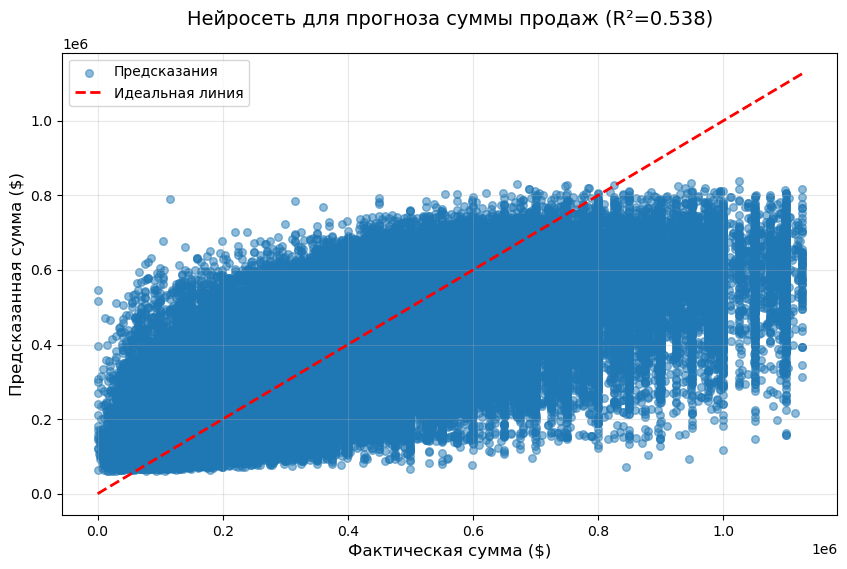

In [34]:
plt.figure(figsize=(10, 6))

# Фактические vs предсказанные значения
plt.scatter(y_test, nn_predictions, alpha=0.5, s=30, label='Предсказания')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Идеальная линия')

plt.xlabel('Фактическая сумма ($)', fontsize=12)
plt.ylabel('Предсказанная сумма ($)', fontsize=12)
plt.title(f'Нейросеть для прогноза суммы продаж (R²={r2_score(y_test, nn_predictions):.3f})', 
          fontsize=14, pad=20)
plt.legend()
plt.grid(True, alpha=0.3)

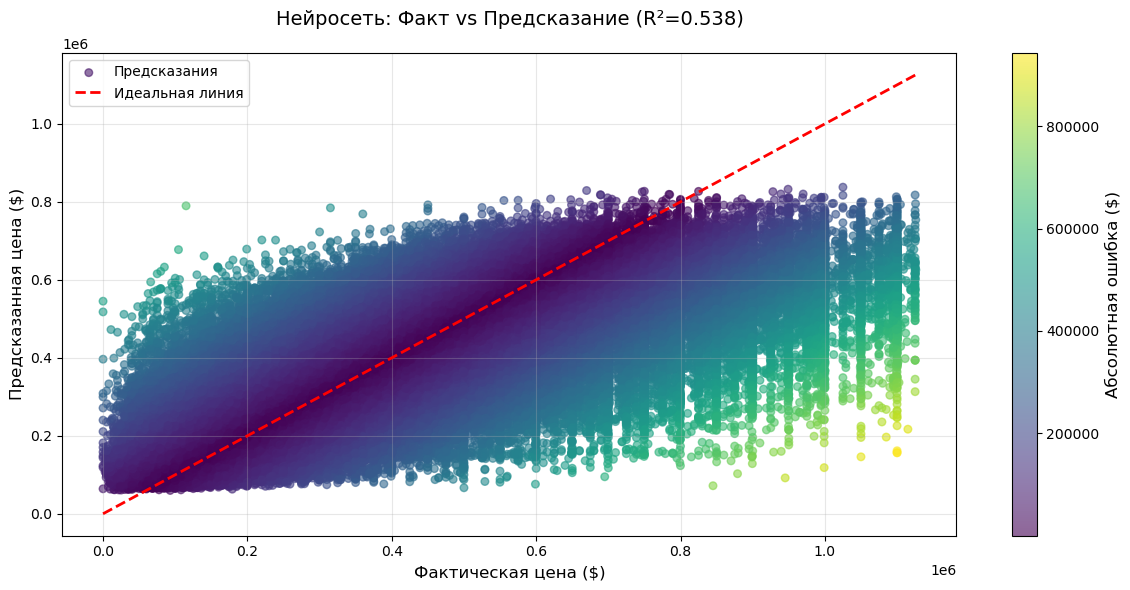

In [35]:
plt.figure(figsize=(12, 6))

# Вычисляем ошибки для цветового кодирования
errors = np.abs(y_test - nn_predictions)

# Точечный график с цветом по величине ошибки
scatter = plt.scatter(y_test, nn_predictions, 
                     c=errors, 
                     cmap='viridis', 
                     alpha=0.6, 
                     s=30,
                     label='Предсказания')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Идеальная линия')

plt.xlabel('Фактическая цена ($)', fontsize=12)
plt.ylabel('Предсказанная цена ($)', fontsize=12)
plt.title(f'Нейросеть: Факт vs Предсказание (R²={r2_score(y_test, nn_predictions):.3f})', 
          fontsize=14, pad=20)

# Добавляем colorbar для ошибок
cbar = plt.colorbar(scatter)
cbar.set_label('Абсолютная ошибка ($)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Нейросеть предсказала хуже,  с результатом 0.53
## Причины
### Отсутствие категориальных переменных
### Цены на недвижимость имеют сложные нелинейные зависимости
### Для табличных данных сложные нейросети часто проигрывают деревьям

# Вывод

### XGBoost - оптимальный выбор. Нейросети требуют более сложных данных и архитектур для раскрытия своего потенциала.